# Sales prediction using timeseries and multivariate

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from math import sqrt
from statistics import mean, stdev

import warnings
warnings.filterwarnings("ignore")


In [4]:
data=pd.read_csv("data/Train_KQyJ5eh.csv")

In [5]:
data.shape

(587, 2)

In [6]:
data.head()

,Date,Number_SKU_Sold
0,1-Jan-07,31762
1,2-Jan-07,285955
2,3-Jan-07,740781
3,4-Jan-07,508796
4,5-Jan-07,445951


In [7]:
#preprocess the data

In [10]:
data['Date']=pd.to_datetime(data['Date'])
data.index=data['Date']

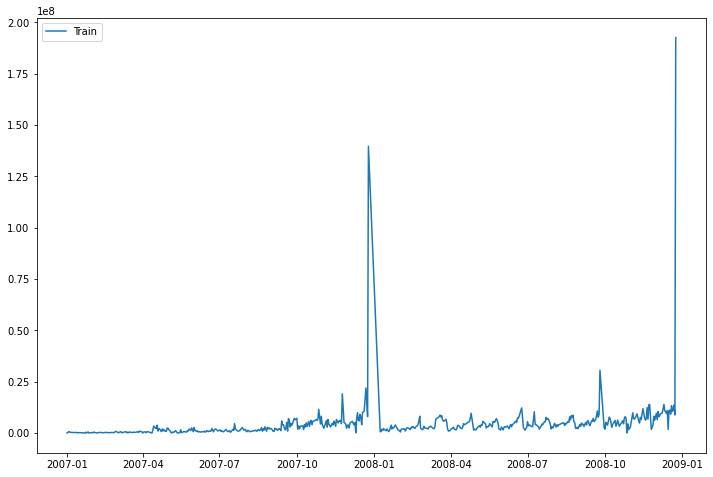

In [12]:
plt.figure(figsize=(12,8))
plt.plot(data.index,data['Number_SKU_Sold'],label='Train')
plt.legend()
plt.show()

outlier is present in data

In [13]:
data['Number_SKU_Sold'].describe()

count    5.870000e+02
mean     4.118112e+06
std      1.015100e+07
min      3.176200e+04
25%      1.075948e+06
50%      2.784444e+06
75%      5.208588e+06
max      1.925327e+08
Name: Number_SKU_Sold, dtype: float64

In [14]:
data['Number_SKU_Sold'].median()

2784444.0

In [15]:
print('value of 95th percentile',(np.percentile(data['Number_SKU_Sold'],95)))
print('value of 98th percentile',(np.percentile(data['Number_SKU_Sold'],98)))
print('value of 99th percentile',(np.percentile(data['Number_SKU_Sold'],99)))

value of 95th percentile 9855528.099999992
value of 98th percentile 12324744.119999997
value of 99th percentile 14225472.619999975


<AxesSubplot:xlabel='Number_SKU_Sold'>

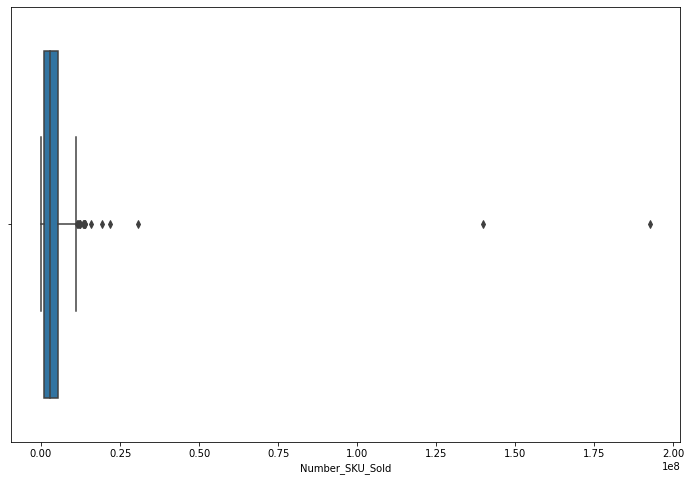

In [17]:
plt.figure(figsize=(12,8))
sns.boxplot(data['Number_SKU_Sold'])

In [19]:
IQR=np.percentile(data['Number_SKU_Sold'],75)-np.percentile(data['Number_SKU_Sold'],25)
whishker_end=np.percentile(data['Number_SKU_Sold'],75)+1.5*IQR

In [20]:
whishker_end

11407547.25

In [21]:
data.loc[data['Number_SKU_Sold']>whishker_end]

,Date,Number_SKU_Sold
Date,,
2007-10-27,2007-10-27,11572492
2007-11-24,2007-11-24,19138073
2007-12-22,2007-12-22,21956074
2007-12-23,2007-12-23,15766750
2007-12-25,2007-12-25,139629635
2008-06-24,2008-06-24,12288917
2008-09-25,2008-09-25,30579435
2008-11-15,2008-11-15,11930320
2008-11-20,2008-11-20,12416871


In [23]:
data_original=data['Number_SKU_Sold']
data['Number_SKU_Sold']=data['Number_SKU_Sold'].apply(lambda x:np.nan if x > whishker_end else x)

In [24]:
data['Number_SKU_Sold'].isnull().sum()

16

In [26]:
data['Number_SKU_Sold']=data['Number_SKU_Sold'].fillna(method='ffill')

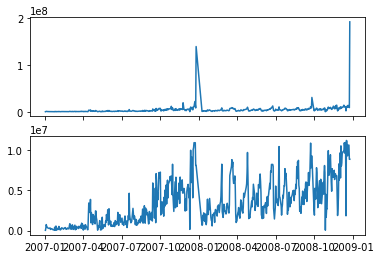

In [38]:
fig, axs = plt.subplots(2, 1,  sharex=True)

axs[0].plot(data_original,) 
axs[1].plot(data['Number_SKU_Sold'])
plt.show() 

In [39]:
#Missing value in data

In [43]:
data['Number_SKU_Sold'].shape

(587,)

In [41]:
data['Date'].max(),data['Date'].min(),data['Date'].max()-data['Date'].min()

(Timestamp('2008-12-24 00:00:00'),
 Timestamp('2007-01-01 00:00:00'),
 Timedelta('723 days 00:00:00'))

In [46]:
pd.date_range(start='2007-01-01',end='2008-12-24').difference(data.index)

DatetimeIndex(['2007-01-07', '2007-01-08', '2007-01-10', '2007-01-14',
               '2007-01-17', '2007-01-21', '2007-01-25', '2007-01-28',
               '2007-02-04', '2007-02-10',
               ...
               '2008-11-01', '2008-11-02', '2008-11-07', '2008-11-09',
               '2008-11-14', '2008-11-16', '2008-11-24', '2008-11-30',
               '2008-12-07', '2008-12-09'],
              dtype='datetime64[ns]', length=137, freq=None)

In [47]:
start_date = '2007-01-01'
end_date = '2008-12-24'

In [56]:
missing_dates = pd.DataFrame(data=pd.date_range(start = start_date, end = end_date).difference(data.index), 
                             columns= ['Date'])

In [57]:
missing_dates

,Date
0,2007-01-07
1,2007-01-08
2,2007-01-10
3,2007-01-14
4,2007-01-17
...,...
132,2008-11-16
133,2008-11-24
134,2008-11-30
135,2008-12-07


In [58]:
data.shape

(587, 2)

In [64]:
missing_dates['Day']=missing_dates['Date'].dt.strftime('%A')
missing_dates['Month']=missing_dates['Date'].dt.month
missing_dates['year']=missing_dates['Date'].dt.year


In [65]:
missing_dates.head()

,Date,Day,Month,year
0,2007-01-07,Sunday,1,2007
1,2007-01-08,Monday,1,2007
2,2007-01-10,Wednesday,1,2007
3,2007-01-14,Sunday,1,2007
4,2007-01-17,Wednesday,1,2007


In [72]:
missing_dates['Day'].value_counts()

Sunday       86
Saturday     14
Friday       10
Monday       10
Wednesday     6
Thursday      6
Tuesday       5
Name: Day, dtype: int64

In [73]:
missing_dates['Month'].value_counts()

1     19
6     13
7     13
9     13
3     12
11    12
5     10
10    10
12    10
2      9
4      9
8      7
Name: Month, dtype: int64

In [74]:
pd.crosstab(missing_dates['year'],missing_dates['Day'])

Day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
year,,,,,,,
2007,3,4,6,43,5,1,5
2008,7,6,8,43,1,4,1


In [75]:
#dealing with missing values

In [149]:
data_=pd.DataFrame(data['Number_SKU_Sold'])
data_.index=pd.DatetimeIndex(data.Date)

In [150]:
data_.head

<bound method NDFrame.head of             Number_SKU_Sold
Date                       
2007-01-01          31762.0
2007-01-02         285955.0
2007-01-03         740781.0
2007-01-04         508796.0
2007-01-05         445951.0
...                     ...
2008-12-20       10572461.0
2008-12-21       10572461.0
2008-12-22       10572461.0
2008-12-23        8821786.0
2008-12-24        8821786.0

[587 rows x 1 columns]>

In [151]:
#add missing dates to data
idx=pd.date_range('2007-01-01','2008-12-24')
data_=data_.reindex(idx,fill_value=0)

In [152]:
data_.head(20)

,Number_SKU_Sold
2007-01-01,31762.0
2007-01-02,285955.0
2007-01-03,740781.0
2007-01-04,508796.0
2007-01-05,445951.0
2007-01-06,347351.0
2007-01-07,0.0
2007-01-08,0.0
2007-01-09,269415.0
2007-01-10,0.0


In [153]:
data_['Date']=data_.index
data_['weekday_name']=data_['Date'].dt.strftime("%A")
data_.shape

(724, 3)

In [154]:
data_.dtypes

Number_SKU_Sold           float64
Date               datetime64[ns]
weekday_name               object
dtype: object

In [155]:
# remove sundays from data
data_ = data_.loc[data_['weekday_name'] != 'Sunday']
data_.shape

(621, 3)

In [156]:
data_original = data['Number_SKU_Sold']
data_['Number_SKU_Sold'] = data_['Number_SKU_Sold'].apply(lambda x: np.nan if x == 0.0 else x)
data_.isnull().sum()

Number_SKU_Sold    51
Date                0
weekday_name        0
dtype: int64

In [157]:
#input missing value
data_['Number_SKU_Sold']=data_['Number_SKU_Sold'].fillna(method='ffill')

In [158]:
data_.isnull().sum()

Number_SKU_Sold    0
Date               0
weekday_name       0
dtype: int64

# Feature extraction from the data

In [159]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed_series = seasonal_decompose(data_['Number_SKU_Sold'], period=6)

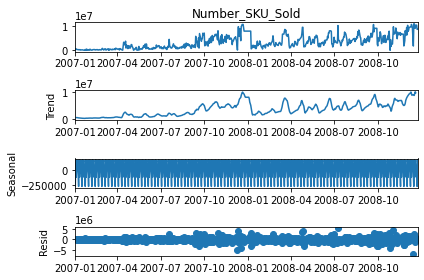

In [162]:
decomposed_series.plot()
plt.show()

<AxesSubplot:>

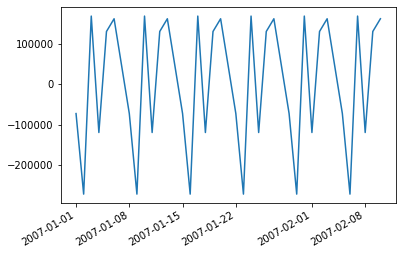

In [163]:
decomposed_series.seasonal[0:36].plot()

In [164]:
data_feat = pd.DataFrame({"year": data_['Date'].dt.year,
                          "month": data_['Date'].dt.month,
                          "day": data_['Date'].dt.day,
                          "weekday": data_['Date'].dt.dayofweek,
                          "weekday_name":data_['Date'].dt.strftime("%A"),
                          "dayofyear": data_['Date'].dt.dayofyear,
                          "week": data_['Date'].dt.week,
                          "quarter": data_['Date'].dt.quarter,
                         })

In [165]:
data_feat

,year,month,day,weekday,weekday_name,dayofyear,week,quarter
2007-01-01,2007,1,1,0,Monday,1,1,1
2007-01-02,2007,1,2,1,Tuesday,2,1,1
2007-01-03,2007,1,3,2,Wednesday,3,1,1
2007-01-04,2007,1,4,3,Thursday,4,1,1
2007-01-05,2007,1,5,4,Friday,5,1,1
...,...,...,...,...,...,...,...,...
2008-12-19,2008,12,19,4,Friday,354,51,4
2008-12-20,2008,12,20,5,Saturday,355,51,4
2008-12-22,2008,12,22,0,Monday,357,52,4
2008-12-23,2008,12,23,1,Tuesday,358,52,4


In [167]:
complete_data = pd.concat([data_feat, data_['Number_SKU_Sold']], axis=1)
complete_data.head()

,year,month,day,weekday,weekday_name,dayofyear,week,quarter,Number_SKU_Sold
2007-01-01,2007,1,1,0,Monday,1,1,1,31762.0
2007-01-02,2007,1,2,1,Tuesday,2,1,1,285955.0
2007-01-03,2007,1,3,2,Wednesday,3,1,1,740781.0
2007-01-04,2007,1,4,3,Thursday,4,1,1,508796.0
2007-01-05,2007,1,5,4,Friday,5,1,1,445951.0


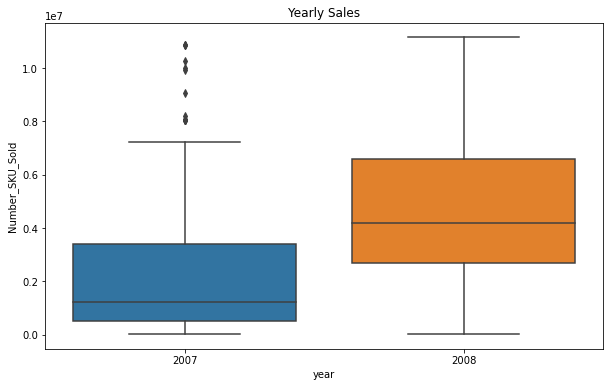

In [168]:
# boxplot for yearly sale
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data['year'], y=complete_data['Number_SKU_Sold'], )
plt.title('Yearly Sales')
plt.show()

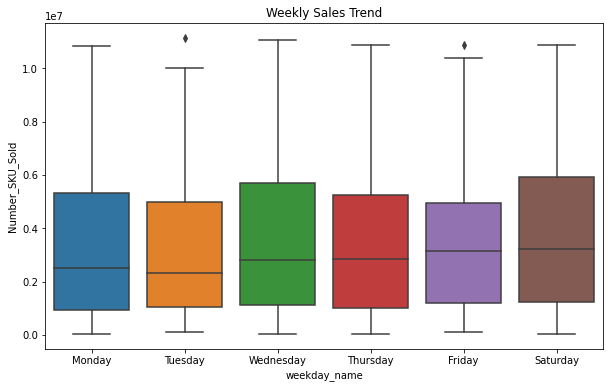

In [169]:
# boxplot for week's sales
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data['weekday_name'], y=complete_data['Number_SKU_Sold'], )
plt.title('Weekly Sales Trend')
plt.show()

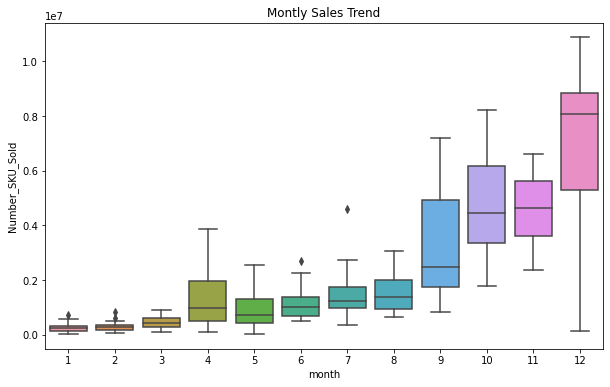

In [172]:
# boxplot for monthly sales
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data.loc[complete_data['year']==2007]['month'], y=complete_data['Number_SKU_Sold'], )
plt.title('Montly Sales Trend')
plt.show()

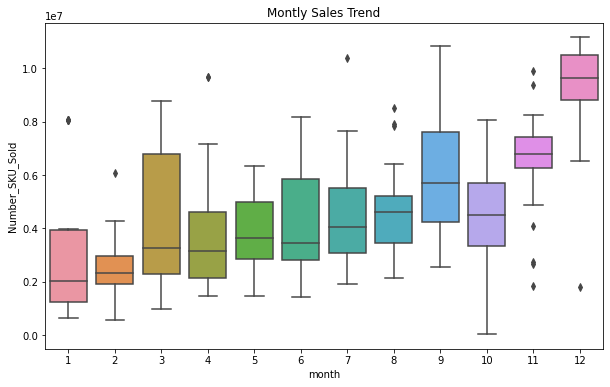

In [173]:
# boxplot for monthly sales
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data.loc[complete_data['year']==2008]['month'], y=complete_data['Number_SKU_Sold'], )
plt.title('Montly Sales Trend')
plt.show()

# HOldout validation

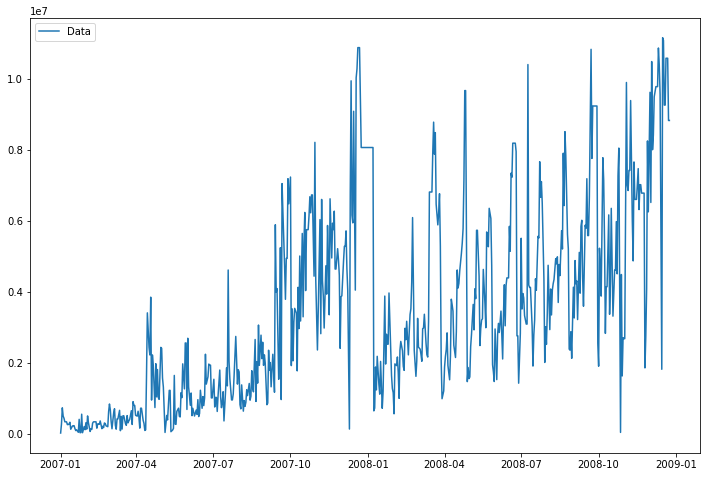

In [174]:
plt.figure(figsize=(12,8))

plt.plot(data_.index, data_['Number_SKU_Sold'], label = 'Data')
plt.legend(loc='best')
plt.show()

In [184]:
train_data=data_[:469]
valid_data=data_[469:]

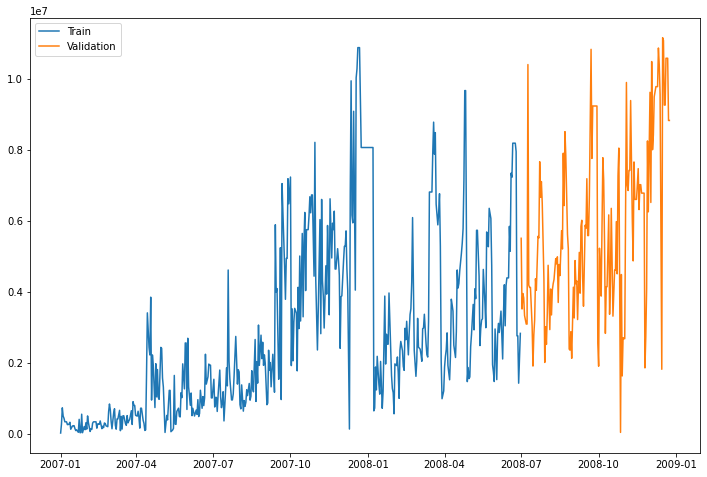

In [185]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data['Number_SKU_Sold'], label='Train')
plt.plot(valid_data.index, valid_data['Number_SKU_Sold'], label='Validation')
plt.legend(loc='best')
plt.show()

In [186]:
def rmsle(actual, preds):
    for i in range(0,len(preds)):
        if preds[i]<0:
            preds[i] = 0
        else:
            pass
    
    error = (sqrt(mean_squared_log_error(actual, preds)))*100
    return error

# Time series forecasting

In [187]:
#using third exponential smoothing
from statsmodels.tsa.api import ExponentialSmoothing

In [188]:
#training the model
model = ExponentialSmoothing(np.asarray(train_data['Number_SKU_Sold']), seasonal_periods=6, trend='add', seasonal='add')
model = model.fit(smoothing_level=0.2, smoothing_slope=0.001, smoothing_seasonal=0.2)
    
# predictions and evaluation
preds = model.forecast(len(valid_data)) 
score = rmsle(valid_data['Number_SKU_Sold'], preds)

# results
print('RMSLE for Holt Winter is:', score)

RMSLE for Holt Winter is: 58.99207676272458


# Grid search

In [189]:
from itertools import product
from tqdm import tqdm_notebook

In [190]:
# setting initial values and some bounds for them
level = [0.1, 0.3, 0.5, 0.8]
smoothing_slope = [0.0001, 0.001, 0.05] 
smoothing_seasonal = [0.2, 0.4, 0.6]

# creating list with all the possible combinations of parameters
parameters = product(level, smoothing_slope, smoothing_seasonal)
parameters_list = list(parameters)
len(parameters_list)

36

In [191]:
def grid_search(parameters_list):
    
    results = []
    best_error_ = float("inf")

    for param in tqdm_notebook(parameters_list):
        #training the model
        model = ExponentialSmoothing(np.asarray(train_data['Number_SKU_Sold']), seasonal_periods=6, trend='add', seasonal='add')
        model = model.fit(smoothing_level=param[0], smoothing_slope=param[1], smoothing_seasonal=param[2])

        # predictions and evaluation
        preds = model.forecast(len(valid_data)) 
        score = rmsle(valid_data['Number_SKU_Sold'], preds)
        
        # saving best model, rmse and parameters
        if score < best_error_:
            best_model = model
            best_error_ = score
            best_param = param
        results.append([param, score])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'RMSLE']
    
    
    # sorting in ascending order, the lower rmse is - the better
    result_table = result_table.sort_values(by='RMSLE', ascending=True).reset_index(drop=True)
    
    return result_table

In [192]:
result_table = grid_search(parameters_list)

  0%|          | 0/36 [00:00<?, ?it/s]

In [193]:
result_table

,parameters,RMSLE
0,"(0.1, 0.0001, 0.2)",58.269876
1,"(0.1, 0.001, 0.2)",58.278214
2,"(0.1, 0.0001, 0.4)",60.916507
3,"(0.1, 0.001, 0.4)",60.930322
4,"(0.1, 0.05, 0.4)",61.243131
5,"(0.1, 0.05, 0.2)",62.588756
6,"(0.3, 0.001, 0.2)",66.690354
7,"(0.3, 0.0001, 0.2)",66.741649
8,"(0.1, 0.001, 0.6)",66.849780
9,"(0.1, 0.0001, 0.6)",66.865801


In [194]:
#training the model
model = ExponentialSmoothing(np.asarray(train_data['Number_SKU_Sold']), seasonal_periods=6, trend='add', seasonal='add')
model = model.fit(smoothing_level=0.1, smoothing_slope=0.0001, smoothing_seasonal=0.2)
    
# predictions and evaluation
preds = model.forecast(len(valid_data)) 
score = rmsle(valid_data['Number_SKU_Sold'], preds)

# results
print('RMSLE for Holt Winter is:', score)

RMSLE for Holt Winter is: 58.269875755750576


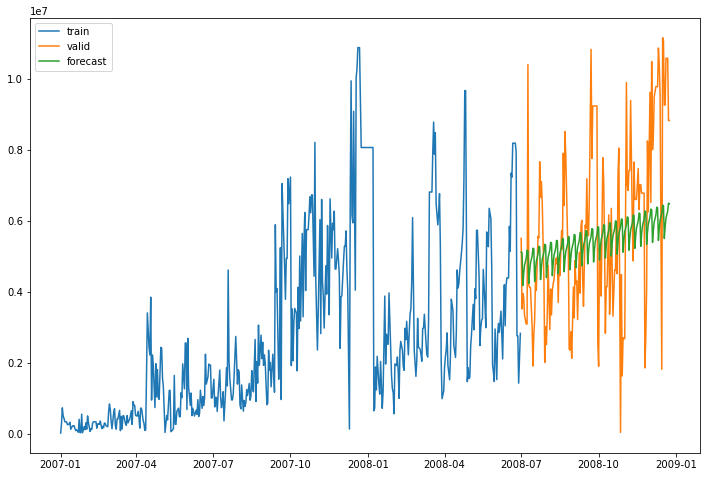

In [195]:
plt.figure(figsize = (12,8))

plt.plot(train_data.index , train_data['Number_SKU_Sold'], label = 'train')
plt.plot(valid_data.index , valid_data['Number_SKU_Sold'], label = 'valid')
plt.plot(valid_data.index , preds, label = 'forecast')
plt.legend(loc='best')

plt.show()

# using Random forest

In [196]:
from sklearn.ensemble import RandomForestRegressor

In [201]:
train_data = complete_data[:469]
valid_data = complete_data[469:]

In [202]:
# separating features and target variable
x_train = train_data.drop(['Number_SKU_Sold','weekday_name'], axis=1)
y_train = train_data['Number_SKU_Sold']

x_valid = valid_data.drop(['Number_SKU_Sold', 'weekday_name'], axis=1)
y_valid = valid_data['Number_SKU_Sold']

In [203]:
#training the model
model = RandomForestRegressor(n_estimators=100, max_depth=7, min_samples_split = 25, random_state=0)
model.fit(x_train, y_train)
    
# predictions 
preds = model.predict(x_valid)

score = rmsle(y_valid, preds)
   
# results
print('Average Error is',score)

Average Error is 57.08567074733863


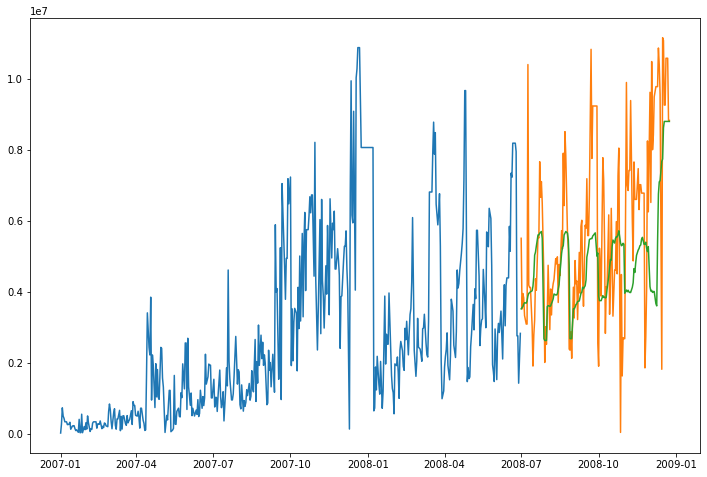

In [204]:
plt.figure(figsize = (12,8))

plt.plot(train_data.index, train_data['Number_SKU_Sold'], label = 'train')
plt.plot(valid_data.index, valid_data['Number_SKU_Sold'], label = 'valid')
plt.plot(valid_data.index, preds, label = 'preds')
plt.show()